- feature: pclass, sex, fare
- label: survived

1. 1등급, female, 32달러 인경우 생사유무를 예측하시요
( voting , bagging, boost, deep learning 을 이용하시요) 
2. 위의 모델의 train, test, f1 score 를 구하시요
3. confusion matrix 를 구하고 heatmap 을 그리시요.
4. roc curve 를 그리시요.


In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score,roc_curve
from xgboost import XGBClassifier
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
plt.rcParams['font.family']='Malgun Gothic'
#그래프의 크기
plt.rcParams['figure.figsize']=12.8,10.8
#글자크기
plt.rcParams['font.size']=14
#폰트설정시 -가호 깨지는거 방지하기
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.facecolor']='white' #다크모드일때 그래프에 흰배경깔아줌
import seaborn as sns

# 데이터 불러오기 & 확인

In [2]:
titanic=sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


# train, test 데이터 나누기

In [3]:
x_data = titanic[['pclass', 'sex', 'fare']]
y_data = titanic[['survived']]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, stratify = y_data, random_state = 1)

# encoding

In [4]:
mct = make_column_transformer(  ( OneHotEncoder(), ['sex'] ), remainder = 'passthrough' )

# (1) voting

In [5]:
model_logi = make_pipeline( mct, StandardScaler(), LogisticRegression() )
model_knn = make_pipeline( mct, StandardScaler(), KNeighborsClassifier() )
model_tree = make_pipeline( mct, StandardScaler(), DecisionTreeClassifier() )

In [6]:
model_vote = VotingClassifier(estimators = [('logi', model_logi), ('knn', model_knn), ('tree', model_tree)], voting = 'soft')
model_vote.fit(x_train, y_train)

VotingClassifier(estimators=[('logi',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('onehotencoder',
                                                                                OneHotEncoder(),
                                                                                ['sex'])])),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression())])),
                             ('knn',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(remainder='passthrough',
                                                 

## 1) voting predict


In [7]:
q1 = pd.DataFrame([1, 'female', 32]).T
q1.columns = x_data.columns

print('1등급, female, 32달러인 사람의 voting 생존여부는', model_vote.predict(q1)[0],'로 생존할 가능성이 크다.')

1등급, female, 32달러인 사람의 voting 생존여부는 1 로 생존할 가능성이 크다.


## 2) voting f1 score

In [8]:
print('voting train f1 score : ', metrics.f1_score(y_train, model_vote.predict(x_train), average='macro'))
print('voting test f1 score : ', metrics.f1_score(y_test, model_vote.predict(x_test), average='macro'))

voting train f1 score :  0.8825092827828805
voting test f1 score :  0.8158146409320117


## 3) voting confusion_matrix,  roc curve

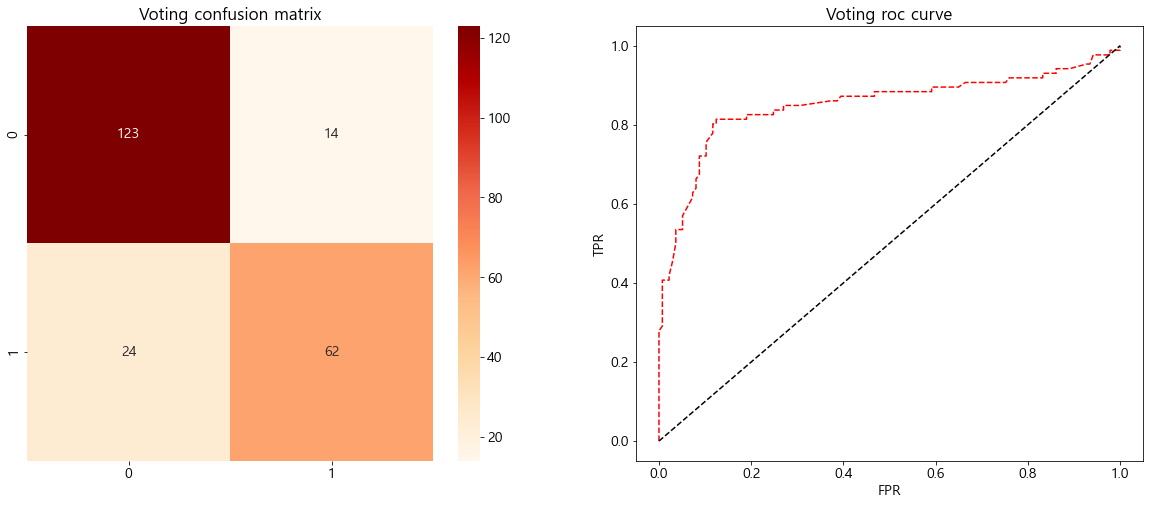

In [26]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].set_title('Voting confusion matrix')
sns.heatmap(metrics.confusion_matrix(y_test,model_vote.predict(x_test)), annot=True, cmap = 'OrRd', ax=ax[0],fmt= 'd')

pred_proba = model_vote.predict_proba(x_test)
fpr ,tpr, _ = metrics.roc_curve(y_test,pred_proba[:,1])

ax[1].plot(fpr,tpr, 'r--')
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_title('Voting roc curve')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
plt.show()

# (2) bagging

In [10]:
model_bagg = make_pipeline( mct, StandardScaler(), BaggingClassifier() )
model_bagg.fit(x_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['sex'])])),
                ('standardscaler', StandardScaler()),
                ('baggingclassifier', BaggingClassifier())])

## 1) bagging predict

In [11]:
q1 = pd.DataFrame([1, 'female', 32]).T
q1.columns = x_data.columns

print('1등급, female, 32달러인 사람의 bagging 생존여부는', model_bagg.predict(q1)[0],'로 생존할 가능성이 크다.')


1등급, female, 32달러인 사람의 bagging 생존여부는 1 로 생존할 가능성이 크다.


## 2) bagging f1 score

In [12]:
print('bagging train f1 score : ', metrics.f1_score(y_train, model_bagg.predict(x_train), average='macro'))
print('bagging test f1 score : ', metrics.f1_score(y_test, model_bagg.predict(x_test), average='macro'))


bagging train f1 score :  0.8968688184493656
bagging test f1 score :  0.8037688064730755


## 3) bagging confusion_matrix,  roc curve

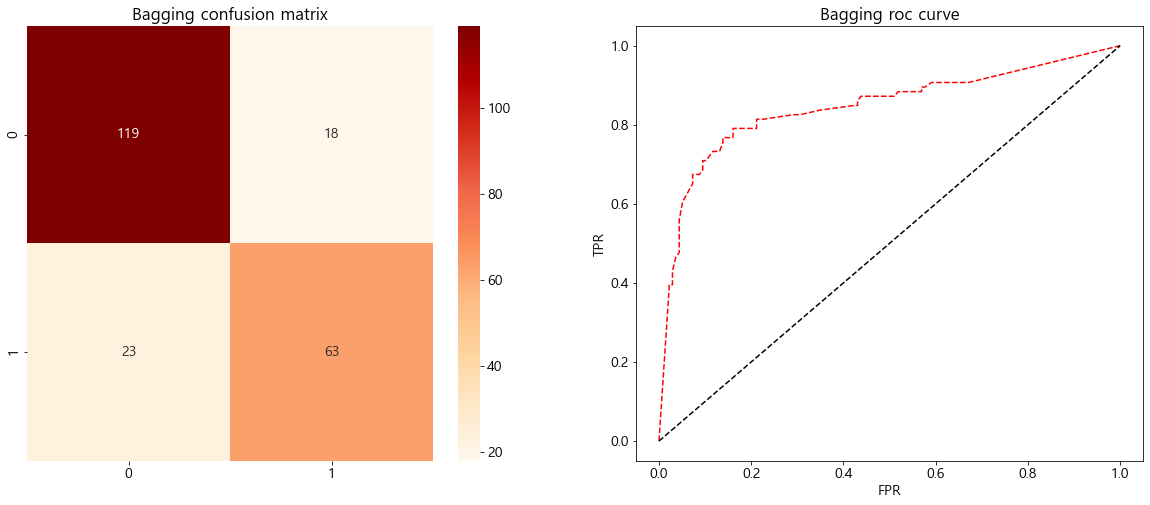

In [27]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].set_title('Bagging confusion matrix')
sns.heatmap(metrics.confusion_matrix(y_test,model_bagg.predict(x_test)), annot=True, cmap = 'OrRd', ax=ax[0],fmt= 'd')

pred_proba = model_bagg.predict_proba(x_test)
fpr ,tpr, _ = metrics.roc_curve(y_test,pred_proba[:,1])

ax[1].plot(fpr,tpr, 'r--')
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_title('Bagging roc curve')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
plt.show()

# (3) boost

In [14]:
xgb = XGBClassifier()
model_xgb = make_pipeline(mct, xgb)
model_xgb.fit(x_train,y_train)

[19:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['sex'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             

## 1) boost predict

In [15]:
q1 = pd.DataFrame([1, 'female', 32]).T
q1.columns = x_data.columns

print('1등급, female, 32달러인 사람의 boost 생존여부는', model_xgb.predict(q1)[0],'로 생존할 가능성이 크다.')

1등급, female, 32달러인 사람의 boost 생존여부는 1 로 생존할 가능성이 크다.


## 2) boost f1 score

In [16]:
print('boost train f1 score : ', metrics.f1_score(y_train, model_xgb.predict(x_train), average='macro'))
print('boost test f1 score : ', metrics.f1_score(y_test, model_xgb.predict(x_test), average='macro'))

boost train f1 score :  0.8805482523971544
boost test f1 score :  0.829655406552368


## 3) boost confusion_matrix,  roc curve

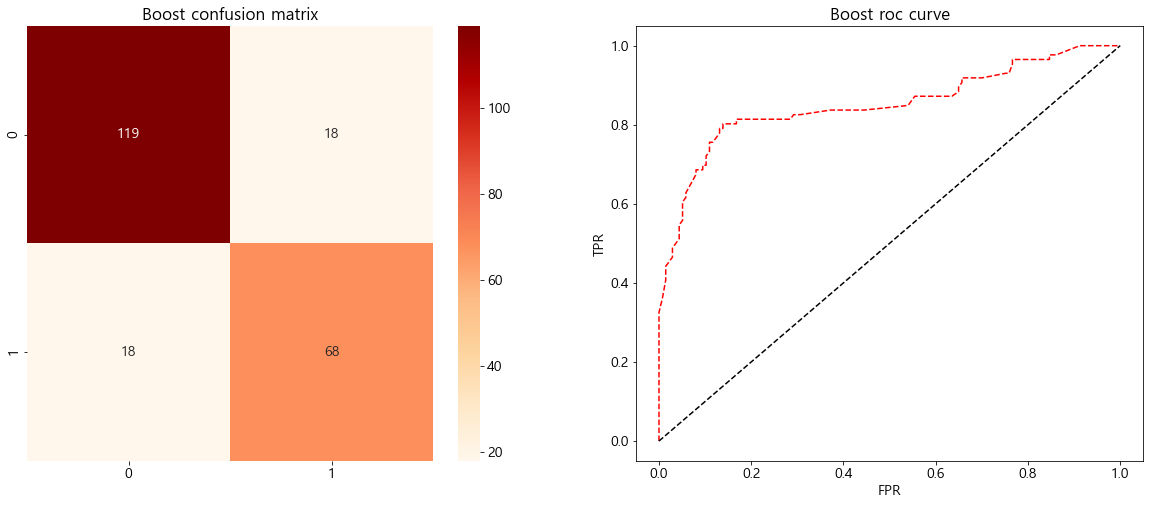

In [28]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].set_title('Boost confusion matrix')
sns.heatmap(metrics.confusion_matrix(y_test,model_xgb.predict(x_test)), annot=True, cmap = 'OrRd', ax=ax[0],fmt= 'd')

pred_proba = model_xgb.predict_proba(x_test)
fpr ,tpr, _ = metrics.roc_curve(y_test,pred_proba[:,1])

ax[1].plot(fpr,tpr, 'r--')
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_title('Boost roc curve')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
plt.show()

# (4) mlp

In [18]:
model_mlp=make_pipeline(mct,MLPClassifier(hidden_layer_sizes=(64,32),max_iter=2000))
model_mlp.fit( x_data,y_data)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['sex'])])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=2000))])

## 1) mlp predict

In [19]:
q1 = pd.DataFrame([1, 'female', 32]).T
q1.columns = x_data.columns

print('1등급, female, 32달러인 사람의 mlp 생존여부는', model_mlp.predict(q1)[0],'로 생존할 가능성이 크다.')

1등급, female, 32달러인 사람의 mlp 생존여부는 1 로 생존할 가능성이 크다.


## 2) mlp f1 score

In [20]:
print('mlp train f1 score : ', metrics.f1_score(y_train, model_mlp.predict(x_train), average='macro'))
print('mlp test f1 score : ', metrics.f1_score(y_test, model_mlp.predict(x_test), average='macro'))

mlp train f1 score :  0.7670516972875883
mlp test f1 score :  0.7803614251455979


## 3) mlp confusion_matrix,  roc curve

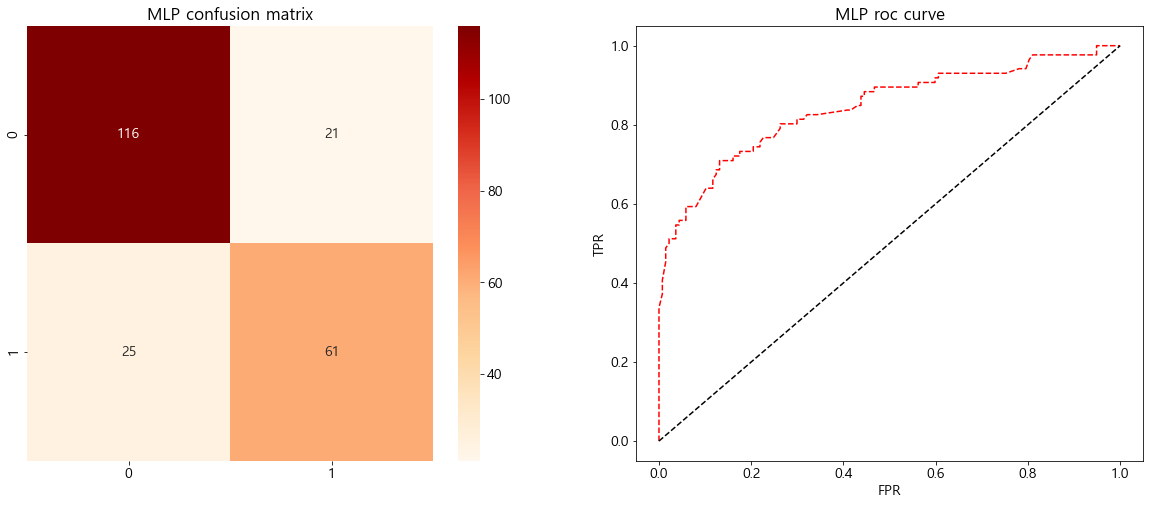

In [29]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].set_title('MLP confusion matrix')
sns.heatmap(metrics.confusion_matrix(y_test,model_mlp.predict(x_test)), annot=True, cmap = 'OrRd', ax=ax[0],fmt= 'd')

pred_proba = model_mlp.predict_proba(x_test)
fpr ,tpr, _ = metrics.roc_curve(y_test,pred_proba[:,1])

ax[1].plot(fpr,tpr, 'r--')
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_title('MLP roc curve')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
plt.show()

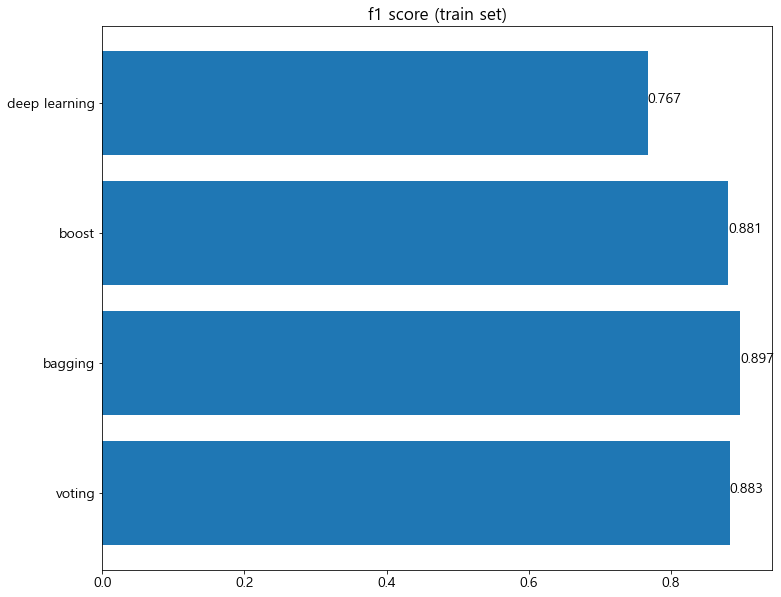

In [24]:
plt.figure(figsize = (12,10))
plt.barh(['voting' , 'bagging', 'boost', 'deep learning'], [metrics.f1_score(y_train, model_vote.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_bagg.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_xgb.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_mlp.predict(x_train), average='macro')])
f1_score_train = [metrics.f1_score(y_train, model_vote.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_bagg.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_xgb.predict(x_train), average='macro'), 
        metrics.f1_score(y_train, model_mlp.predict(x_train), average='macro')]
for i, v in enumerate(f1_score_train):
    plt.text(v, i, str(np.round(v,3)))
plt.title('f1 score (train set)')
plt.show()

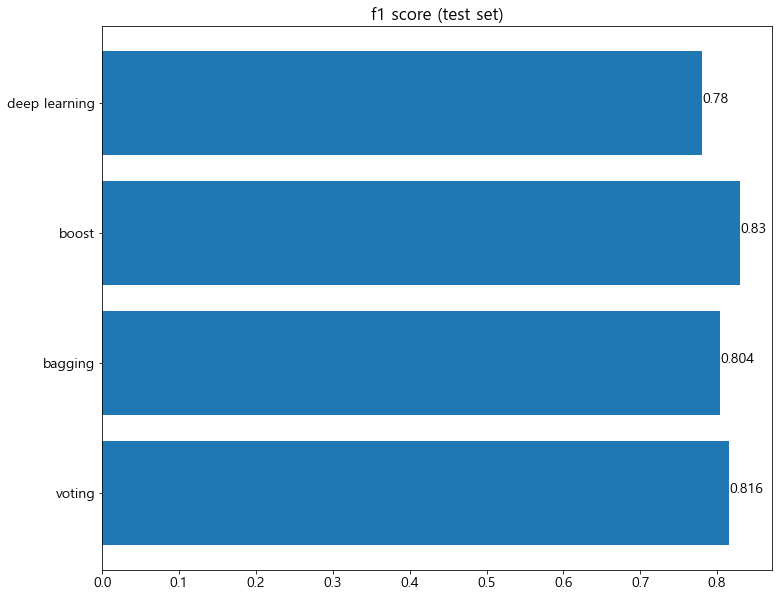

In [25]:
plt.figure(figsize = (12,10))
plt.barh(['voting' , 'bagging', 'boost', 'deep learning'], [metrics.f1_score(y_test, model_vote.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_bagg.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_xgb.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_mlp.predict(x_test), average='macro')])
f1_score_test = [metrics.f1_score(y_test, model_vote.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_bagg.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_xgb.predict(x_test), average='macro'), 
        metrics.f1_score(y_test, model_mlp.predict(x_test), average='macro')]
for i, v in enumerate(f1_score_test):
    plt.text(v, i, str(np.round(v,3)))
plt.title('f1 score (test set)')
plt.show()